In [405]:
import torch
import torch.nn as nn
import torch.optim as optim
from oil.model_trainers.classifierTrainer import ClassifierTrainer
from oil.model_trainers.svrgTrainer3 import SVRGTrainer
from oil.datasetup.datasets import CIFAR10, C10augLayers
from oil.datasetup.dataloaders import getUnlabLoader, getLabLoader
from oil.architectures.networkparts import layer13,ConvSmallNWN
from oil.utils.utils import cosLr, loader_to
from oil.extra.SVRG import SVRG
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [407]:
train_epochs = 25
problem_config =    {'numClasses':500,'numFeatures':500,'dataset_size':10000}
loader_config =     {'batch_size':100}
opt_config =        {'lr':.03, 'momentum':.9, 'weight_decay':1e-7, 'nesterov':True}
sched_config =      {'cycle_length':train_epochs,'cycle_mult':1}
trainer_config =    {'log_args':{'no_print':True, 'minPeriod':0, 'timeFrac':4/10}}

trainer_config['log_dir'] = '/home/maf388/tb-experiments2/convex_toy'
trainer_config['description'] = 'Convex Problem, SGD'

In [408]:
device = torch.device('cuda')
N,D,C = problem_config['dataset_size'], problem_config['numFeatures'], problem_config['numClasses']
x = torch.randn(N, D)
y_logits = x.matmul(D/10. * torch.rand(D, C)) + 0.3 * torch.randn(N, C)
y = torch.distributions.Categorical(logits=y_logits).sample()

dataset = torch.utils.data.TensorDataset(x.to(device), y.to(device))
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset,shuffle=True, **loader_config)

In [409]:
def makeSGDTrainer():
    model = nn.Linear(D,C).to(device)
    opt_constr = lambda params: optim.SGD(params, **opt_config)
    lr_sched = lambda e:32#cosLr(**sched_config)
    return ClassifierTrainer(model, dataloaders, opt_constr, lr_sched, **trainer_config)

In [410]:
def makeSVRGTrainer():
    model = nn.Linear(D,C).to(device)
    opt_constr = lambda params: SVRG(params, **opt_config)
    lr_sched = lambda e:16#cosLr(**sched_config)
    return SVRGTrainer(model, dataloaders, opt_constr, lr_sched, **trainer_config)

In [411]:
sgdTrainer = makeSGDTrainer()
sgdTrainer.train(train_epochs)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

In [412]:
svrgTrainer = makeSVRGTrainer()
svrgTrainer.train(train_epochs)

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

Text(0,0.5,'Loss')

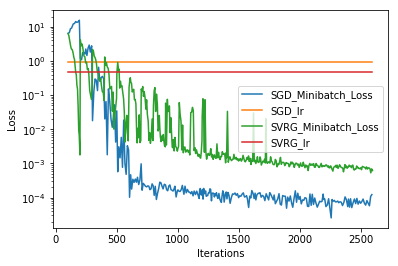

In [309]:
k = 5000
ax = sgdTrainer.logger.scalar_frame.loc[:k].add_prefix('SGD_').plot()
svrgTrainer.logger.scalar_frame.loc[:k].add_prefix('SVRG_').plot(ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')

In [310]:
for i,mb in enumerate(dataloaders['train']):
    if i==2:
        print(mb[0].mean())
        break

tensor(1.00000e-03 *
       5.2804, device='cuda:0')


In [317]:
unique_vals = set(mb[1].sum().cpu() for mb in dataloaders['train'])

In [318]:
unique_vals2 = set(mb[1].sum().cpu() for mb in dataloaders['train'])

In [320]:
unique_vals

{tensor(22344),
 tensor(22550),
 tensor(22613),
 tensor(22777),
 tensor(22900),
 tensor(23004),
 tensor(23033),
 tensor(23164),
 tensor(23226),
 tensor(23254),
 tensor(23388),
 tensor(23453),
 tensor(23456),
 tensor(23520),
 tensor(23531),
 tensor(23559),
 tensor(23577),
 tensor(23617),
 tensor(23626),
 tensor(23689),
 tensor(23694),
 tensor(23794),
 tensor(23801),
 tensor(23916),
 tensor(23921),
 tensor(23927),
 tensor(24110),
 tensor(24146),
 tensor(24155),
 tensor(24182),
 tensor(24253),
 tensor(24289),
 tensor(24367),
 tensor(24385),
 tensor(24401),
 tensor(24414),
 tensor(24436),
 tensor(24444),
 tensor(24472),
 tensor(24479),
 tensor(24489),
 tensor(24557),
 tensor(24641),
 tensor(24662),
 tensor(24698),
 tensor(24736),
 tensor(24740),
 tensor(24830),
 tensor(24880),
 tensor(25006),
 tensor(25090),
 tensor(25095),
 tensor(25114),
 tensor(25161),
 tensor(25168),
 tensor(25192),
 tensor(25195),
 tensor(25232),
 tensor(25235),
 tensor(25254),
 tensor(25310),
 tensor(25319),
 tensor(

In [291]:
for i,mb in enumerate(dataloaders['train']):
    if i==2:
        print(mb[0])
        break

tensor([[ 1.2314e+00, -4.3915e-02,  8.0913e-01,  ...,  1.1633e+00,
         -1.3184e+00,  6.2645e-01],
        [ 2.5756e-01,  4.5602e-01,  8.5494e-01,  ..., -1.1285e+00,
         -8.9633e-01,  2.1554e+00],
        [ 1.1207e+00,  9.7541e-01,  1.2039e+00,  ..., -5.8332e-01,
          8.4876e-01,  1.1125e+00],
        ...,
        [-4.6198e-01, -7.0883e-02,  1.7293e+00,  ..., -8.1217e-01,
         -1.0711e+00,  4.5217e-01],
        [-6.7374e-01,  1.8469e+00,  1.5110e+00,  ...,  3.3037e-01,
          1.3787e+00,  4.9826e-01],
        [ 1.6509e+00, -5.3634e-02,  1.0682e+00,  ..., -9.5225e-01,
         -5.7078e-01,  4.6243e-01]], device='cuda:0')


In [322]:
import numpy as np
import matplotlib.pyplot as plt


In [383]:
def empirical_M(n):
    f = lambda alpha, x: 2*np.exp(-np.pi*x**2 + alpha*x)/alpha
    x = np.linspace(0,1,n)[:,None]
    alpha = np.logspace(-3,1,n)[None,:]
    maxes = np.max(f(alpha,x),axis=0)
    return np.min(maxes)

In [384]:
M = np.sqrt(2*np.exp(1)/np.pi)

In [400]:
ns = np.logspace(1,3.5,30).astype(np.int)
errs =  [np.abs(1/M - 1/empirical_M(n)) for n in ns]

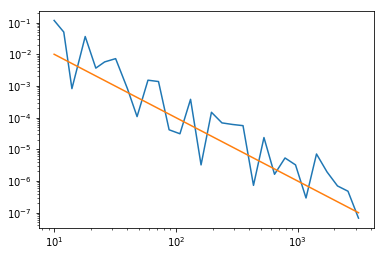

In [401]:
plt.plot(ns,errs)
plt.plot(ns,1/ns**2)
plt.yscale('log')
plt.xscale('log')

In [382]:
ns

array([  10,   16,   27,   46,   77,  129,  215,  359,  599, 1000])

In [361]:
alpha[0,np.argmin(maxes)]

2.5049415421745023

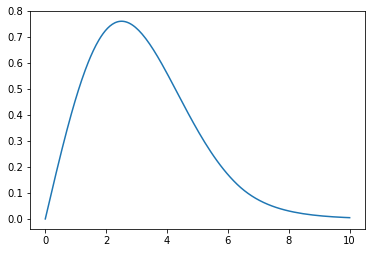

In [363]:
plt.plot(alpha[0],1/maxes)